<a href="https://colab.research.google.com/github/JonathanMartignon/DeepLearningIntroduction/blob/main/Tarea1/Ejercicio4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Entrena una red completamente conectada para clasificación multiclase en el conjunto CIFAR10

Por: 
- Martiñón Luna Jonathan José

Nota: El ejercicio presente se basó en la libreta ''**Clasificación de MNIST con un red densa**''

---
## 1) Librerías
---

In [119]:
import torch
import torch.nn as nn
from tqdm import trange
import torch.optim as optim
from torchinfo import summary
import torch.nn.functional as F
import torchvision.transforms as T
from itertools import islice as take
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt

import numpy as np

import random

---

## 2) Funciones

---

In [144]:
def display_grid(xs, titles, clases,rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            try:
              titl = int(titles[i])
              ax[r, c].set_title(clases.get(titl,titl))
            except:
              ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()

In [121]:
def display_batch(x, titles,clases, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # Anteriormente trabajamos 1 canal (B/n)
    # Ahora son 3 (RGB)
    x = x.reshape(*x.shape[:3],3)
    # desplegamos
    display_grid(x, titles,clases, rows, cols, figsize)

In [122]:
def set_seed(seed=2209):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [123]:
#------------------------
# Para el entrenamiento
#------------------------

def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()

In [124]:
def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc

In [125]:
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

### 2.1) Declaraciones previas

In [126]:
# directorio de datos
DATA_DIR = '../datos'

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8

# reproducibilidad
set_seed()

Investigando un poco acerca del conjunto de datos, encuentro con que son 10 clases:
0. Airplane 
1. Automobile 
2. Bird 
3. Cat 
4. Deer 
5. Dog 
6. Frog 
7. Horse 
8. Ship 
9. Truck  

In [127]:
# Creamos un diccionario para interpretar de qué imagen se trata
# de forma más visual
clases = {0:"Avión", 1:"Automóvil", 2:"Ave", 3:"Gato",
          4:"Ciervo", 5:"Perro", 6:"Rana", 7:"Caballo",
          8:"Barco",9:"Camión"}

----

## 3) Exploración

---

In [128]:
# creamos un Dataset
ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=True, 
    # convertir la imagen a ndarray
    transform=np.array, 
    # descargar el conjunto
    download=True
)

Files already downloaded and verified


images[0] shape=(32, 32, 3) dtype=uint8


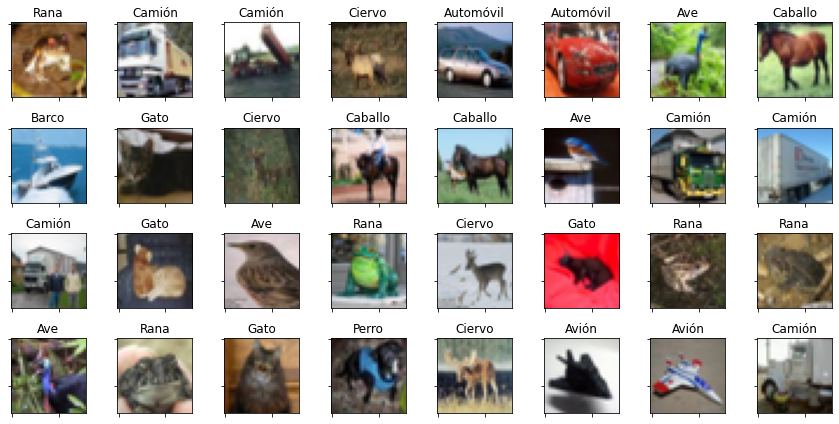

In [129]:
# cargamos algunas imágenes
images, labels = [], []
for i in range(BATCH_SIZE):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles,clases, ROWS, COLS)

---

### 3.1) Entrenamiento

---

x shape=torch.Size([32, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


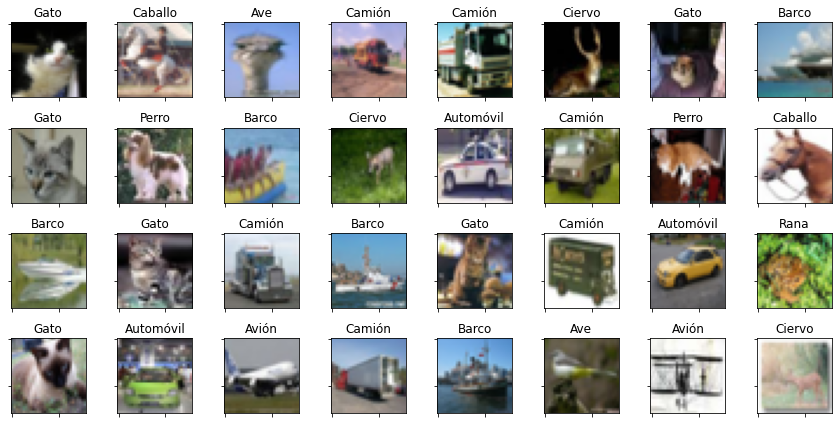

In [130]:
# transformación que convierte una imagen:
#   de numpy.ndarray    (H x W x C) en rango [0, 255]
#   a torch.FloatTensor (C x H x W) en rango [0, 1]
tsfm = T.ToTensor()


#---------------------------
# Conjunto de Entrenamiento del Dataset
#---------------------------

# creamos un Dataset
trn_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm
)

#---------------------------
# Conjunto de Entrenamiento Dataloader
#---------------------------

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size = BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(),clases, ROWS, COLS)

---

### 3.2) Prueba

---

x shape=torch.Size([32, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


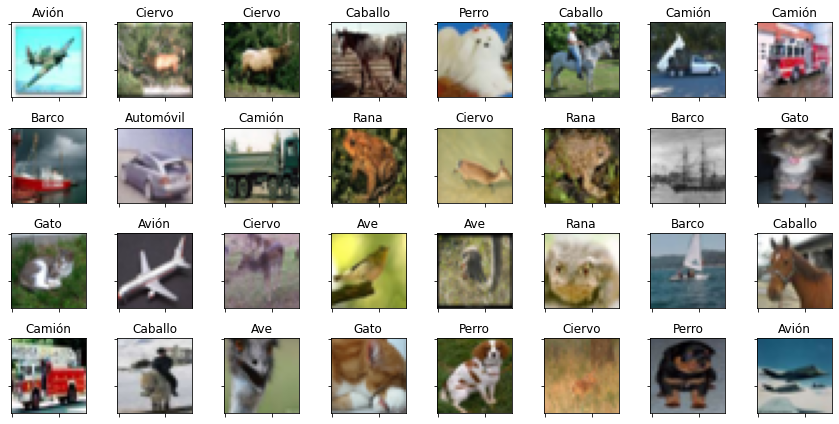

In [131]:

# creamos un Dataset
tst_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(),clases, ROWS, COLS)

## 4) Modelo

In [132]:
# definición del modelo
class FCN(nn.Module):
    
    # inicializador
    def __init__(self):
        
        # inicilización del objeto padre, obligatorio
        super(FCN, self).__init__()
        
        # tamaño de las capas
        # 3 canales, 32 x 32
        self.I = 3 * 32 * 32
        FC1, FC2 = 128, 10
        
        # definición de capas
        self.cls = nn.Sequential(
            
            # fc1
            # [M, 3x32x32] => [M, 128]
            nn.Linear(self.I, FC1),
            nn.Sigmoid(),
            
            # fc2
            # [M, 128] => [M, 10]
            nn.Linear(FC1, FC2)
        
        )
    
    # método para inferencia
    def forward(self, x):
        
        # aplanamos los pixeles de la imagen
        # [M, 3, 32, 32] => [M, 3x32x32]
        x = x.view(-1, self.I)
        
        # inferencia
        # [M, 3x32x32]
        x = self.cls(x)
        
        return x

### 4.1) Instanciación

In [133]:
model = FCN()
print(model)

FCN(
  (cls): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [134]:
# inferencia con datos sintéticos
# suponiendo una imagen de 3 canales 
x = torch.zeros(1, 3, 32, 32)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 32, 32]) => torch.Size([1, 10])


In [135]:
#Inspección de la arquitectura
summary(model, (1, 3, 32,32), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 10]                   --
|    └─Linear: 2-1                       [1, 128]                  393,344
|    └─Sigmoid: 2-2                      [1, 128]                  --
|    └─Linear: 2-3                       [1, 10]                   1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
Total mult-adds (M): 0.79
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 1.58
Estimated Total Size (MB): 1.59

---

## 5) Ciclo de entrenamiento

---

In [136]:
# instanciamos un modelo
model = FCN()
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl)


  5%|▌         | 1/20 [00:20<06:22, 20.13s/it]

E00 loss=[227.21,227.20] acc=[19.82,20.08]



 10%|█         | 2/20 [00:39<06:00, 20.02s/it]

E01 loss=[224.20,224.17] acc=[25.86,26.20]



 15%|█▌        | 3/20 [00:59<05:36, 19.79s/it]

E02 loss=[221.11,221.08] acc=[26.87,27.40]



 20%|██        | 4/20 [01:18<05:16, 19.80s/it]

E03 loss=[217.92,217.89] acc=[26.78,27.31]



 25%|██▌       | 5/20 [01:38<04:56, 19.74s/it]

E04 loss=[214.73,214.71] acc=[28.38,28.56]



 30%|███       | 6/20 [01:57<04:34, 19.60s/it]

E05 loss=[211.78,211.79] acc=[28.96,29.23]



 35%|███▌      | 7/20 [02:17<04:15, 19.67s/it]

E06 loss=[209.13,209.11] acc=[28.93,29.46]



 40%|████      | 8/20 [02:36<03:54, 19.55s/it]

E07 loss=[206.81,206.80] acc=[30.07,30.40]



 45%|████▌     | 9/20 [02:57<03:38, 19.88s/it]

E08 loss=[204.77,204.75] acc=[30.73,30.99]



 50%|█████     | 10/20 [03:20<03:27, 20.80s/it]

E09 loss=[202.96,202.91] acc=[30.01,30.02]



 55%|█████▌    | 11/20 [03:43<03:14, 21.56s/it]

E10 loss=[201.32,201.27] acc=[31.00,30.70]



 60%|██████    | 12/20 [04:05<02:53, 21.63s/it]

E11 loss=[199.88,199.84] acc=[31.43,31.29]



 65%|██████▌   | 13/20 [04:27<02:31, 21.60s/it]

E12 loss=[198.54,198.52] acc=[30.78,30.55]



 70%|███████   | 14/20 [04:47<02:06, 21.06s/it]

E13 loss=[197.37,197.35] acc=[31.48,31.45]



 75%|███████▌  | 15/20 [05:08<01:46, 21.21s/it]

E14 loss=[196.27,196.23] acc=[32.06,31.89]



 80%|████████  | 16/20 [05:29<01:24, 21.24s/it]

E15 loss=[195.28,195.25] acc=[32.04,31.78]



 85%|████████▌ | 17/20 [05:50<01:02, 20.91s/it]

E16 loss=[194.37,194.35] acc=[32.16,32.02]



 90%|█████████ | 18/20 [06:10<00:41, 20.79s/it]

E17 loss=[193.54,193.54] acc=[32.54,32.07]



 95%|█████████▌| 19/20 [06:31<00:20, 20.72s/it]

E18 loss=[192.75,192.76] acc=[32.63,32.39]



100%|██████████| 20/20 [06:50<00:00, 20.51s/it]

E19 loss=[192.07,192.06] acc=[32.79,32.86]


In [136]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

In [136]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

----

## 6) Evaluación

----

In [137]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[192.07,192.08] acc=[32.79,32.86]


### 5.2) inferencia

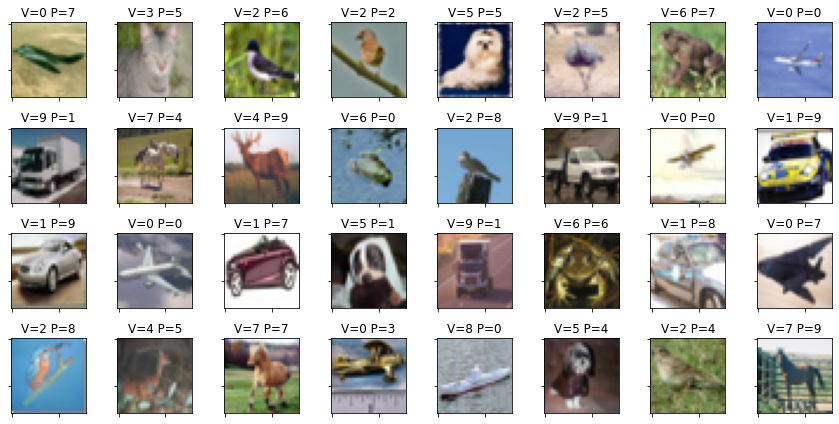

In [145]:
with torch.no_grad(): 
    x, y_true = next(iter(tst_dl))
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x, titles,clases, ROWS, COLS)